# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+
## Заказчик

Приложение Procrastinate Pro+

## Цель проекта

На основе данных, предоставленных компанией, необходимо провести анализ и ответить на вопросы:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.
## Входные данные

Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

лог сервера с данными об их посещениях (файл visits_info_short.csv)
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии;

выгрузка их покупок за этот период (файл orders_info_short.csv)
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа;
 
рекламные расходы (файл costs_info_short.csv)
- Channel — идентификатор рекламного источника,
- Dt — дата проведения рекламной кампании,
- Costs — расходы на эту кампанию.

## Ход исследования

Исследование пройдёт в четыре этапа:

- Обзор и предобработка данных;
- Исследовательский анализ данных;
- Анализ маркетинговых расходов;
- Оценка окупаемости рекламы.

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

visits = visits.rename(columns={'User Id':'user_id','Region':'region','Device':'device','Channel':'channel','Session Start':'session_start','Session End':'session_end'})
orders = orders.rename(columns={'User Id':'user_id','Event Dt':'event_dt','Revenue':'revenue'})
costs = costs.rename(columns={'Channel':'channel'})

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['weeknum'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#Смотрим, есть ли пропуски и дубликаты в данных о визитах
display(visits.isna().sum())
visits.info()
display(visits.duplicated().sum())
#Изачем датасет с заказами
display(orders.isna().sum())
orders.info()
display(orders.duplicated().sum())
#То же самое для затрат
display(costs.isna().sum())
costs.info()
display(costs.duplicated().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


0

user_id     0
event_dt    0
revenue     0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


0

dt         0
channel    0
costs      0
weeknum    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
 3   weeknum  1800 non-null   UInt32 
dtypes: UInt32(1), float64(1), object(2)
memory usage: 51.1+ KB


0

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [2]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [3]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [4]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [5]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [6]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [7]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [8]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [9]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

In [29]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


Момент и горизонт анализа данных.
Согласно заданию, анализ необходимо провести по состоянию на 1 мая 2019 года, но т.к. наша выгрузка содержит данные по 27 октября 2019, возьмем эту дату. В бизнес-плане заложено, что пользователи должны окупаться не позднее, чем через две недели после привлечения.

In [11]:
observation_date = profiles['dt'].max()  # момент анализа
analysis_horizon = 14  # горизонт анализа

# считаем минимальную привлечения
min_analysis_date = datetime(2020, 5, 1).date()

# считаем максимальную дату привлечения
max_analysis_date =  datetime(2020, 10, 27).date() 

print(f'Минимальная дата привлечения пользователей: {min_analysis_date}')
print(f'Максимальная дата привлечения пользователей: {max_analysis_date}')

Минимальная дата привлечения пользователей: 2020-05-01
Максимальная дата привлечения пользователей: 2020-10-27


Страны. Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны и визуализируем ее.

In [12]:
region =  (profiles
           .pivot_table(
                        index='region',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )

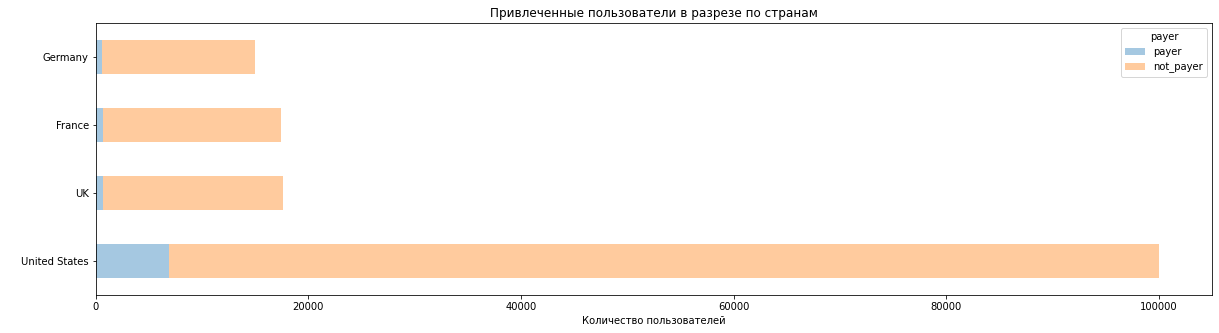

payer,not_payer,payer,payer_share
region,,,
United States,93100,6902,6.90
UK,16875,700,3.98
France,16787,663,3.80
Germany,14365,616,4.11


In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
region[['payer', 'not_payer']].plot(kind='barh', stacked=True, ax=ax, alpha=0.4)

ax.set_xlabel('Количество пользователей')
ax.set_ylabel(' ')
ax.set_title('Привлеченные пользователи в разрезе по странам')
plt.show()

region['payer_share'] = (region.payer / (region.not_payer + region.payer) * 100).round(2)
region

Большинство привлеченных пользователей - из США. Эта же страна лидирует и по количеству платящих пользователей. Франция и Великобритания очень похожи по показателям, а в отстающих - Германия (но при этом по доле платящих пользователей она на втором месте).

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства и визуализируем ее.

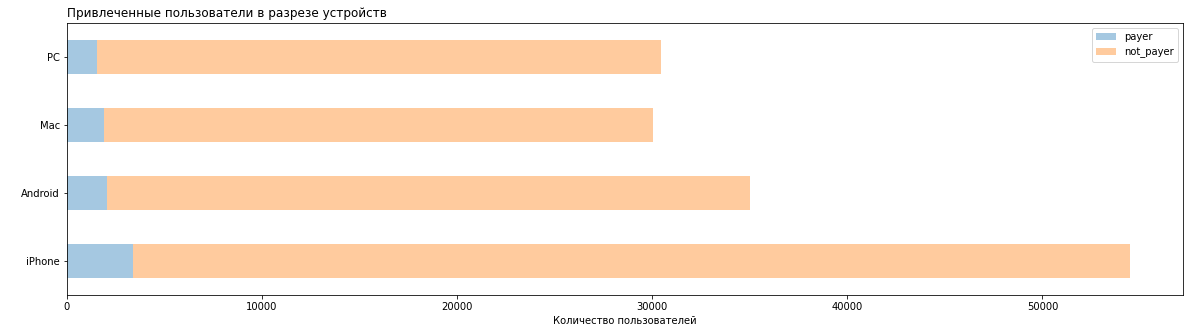

payer,not_payer,payer,payer_share
device,,,
iPhone,51097,3382,6.21
Android,32982,2050,5.85
Mac,28130,1912,6.36
PC,28918,1537,5.05


In [14]:
device =  (profiles
           .pivot_table(
                        index='device',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
fig, ax = plt.subplots(figsize=(20, 5))
device[['payer', 'not_payer']].plot(kind='barh', stacked=True, ax=ax, alpha=0.4)

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Количество пользователей')
ax.set_ylabel(' ')
ax.set_title('Привлеченные пользователи в разрезе устройств',loc='left')
plt.show()

device['payer_share'] = (device.payer / (device.not_payer + device.payer) * 100).round(2)
device

Клиенты предпочитают iOs. Доля клиентов с этих устройств значительно больше.

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения и визуализируем ее.

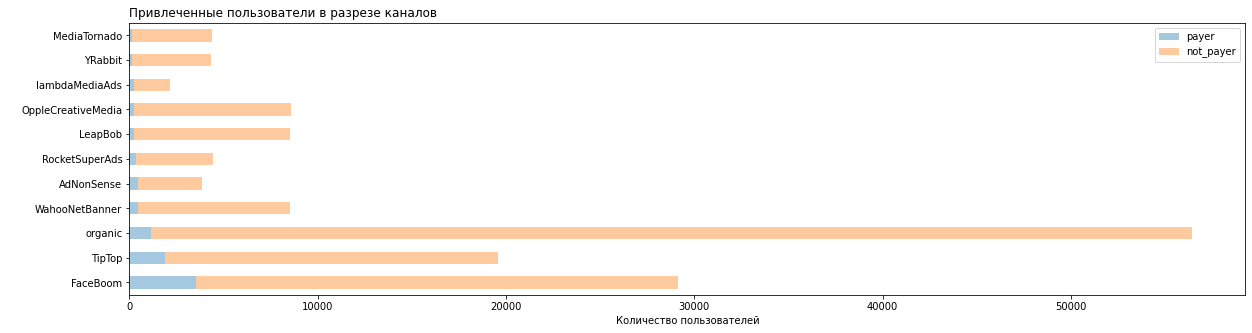

payer,not_payer,payer,payer_share
channel,,,
FaceBoom,25587,3557,12.20
TipTop,17683,1878,9.60
organic,55279,1160,2.06
WahooNetBanner,8100,453,5.30
AdNonSense,3440,440,11.34
RocketSuperAds,4096,352,7.91
LeapBob,8291,262,3.06
OppleCreativeMedia,8372,233,2.71
lambdaMediaAds,1924,225,10.47


In [15]:
channel =  (profiles
           .pivot_table(
                        index='channel',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
fig, ax = plt.subplots(figsize=(20, 5))
channel[['payer', 'not_payer']].plot(kind='barh', stacked=True, ax=ax, alpha=0.4)

ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('Количество пользователей')
ax.set_ylabel(' ')
ax.set_title('Привлеченные пользователи в разрезе каналов',loc='left')
plt.show()

channel['payer_share'] = (channel.payer / (channel.not_payer + channel.payer) * 100).round(2)
channel

Больше всего пользуются приложением органические пользователи, правда их доля конверсии очень низкая. Два самых больших канала - TipTop и FaceBoom показывают неплохие результаты. 

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

Считаем общую сумму расходов на маркетинг

In [16]:
print('Общая сумма затрат на рекламу:', costs['costs'].sum().round())

Общая сумма затрат на рекламу: 105497.0


In [17]:
costs.pivot_table(index='channel',values='costs',aggfunc='sum').sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


<AxesSubplot:title={'center':'Затраты на привлечение пользователей в разрезе каналов по неделям'}>

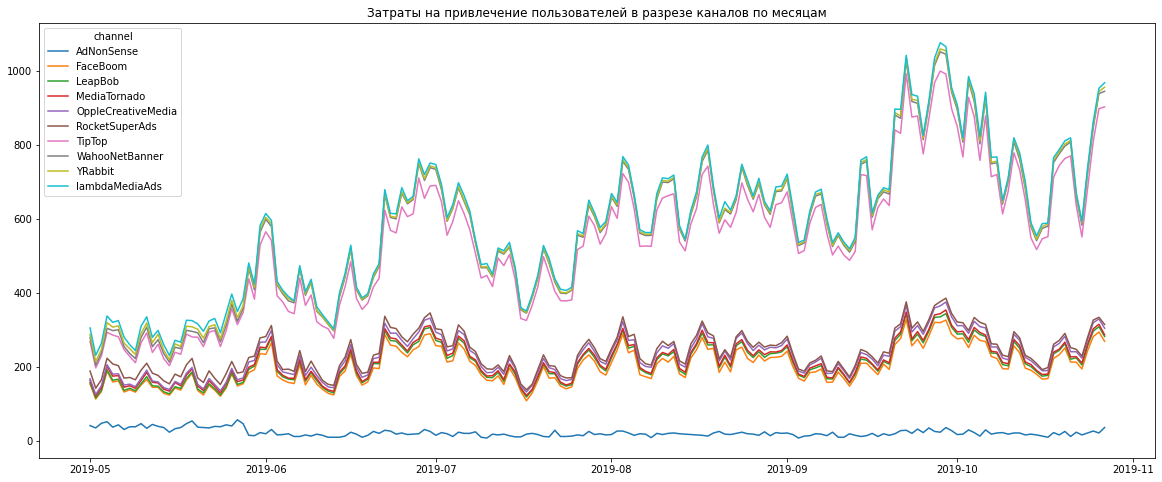

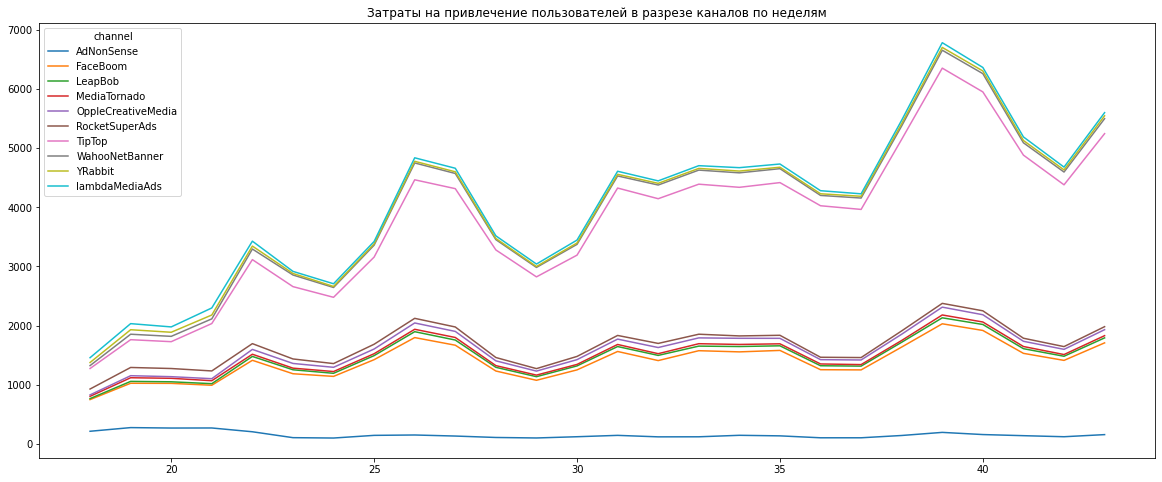

In [18]:
a= costs.pivot_table(
    index=costs.dt,
    values='costs',
    aggfunc='sum',
    columns='channel')
a.plot(figsize=(20,8), stacked=True, title='Затраты на привлечение пользователей в разрезе каналов по месяцам',
                           xlabel='')
a= costs.pivot_table(
    index=costs['weeknum'],
    values='costs',
    aggfunc='sum',
    columns='channel')
a.plot(figsize=(20,8), stacked=True, title='Затраты на привлечение пользователей в разрезе каналов по неделям',
                           xlabel='')


График распределения ов времени говорит о динамике роста трат.

In [19]:
cac_person = (profiles
              .query('channel != "organic"')[['user_id', 'acquisition_cost']]
              .drop_duplicates()
              .agg({'acquisition_cost': 'mean'})
             )
cac_person

acquisition_cost    1.127481
dtype: float64

In [20]:
cac_channel = (profiles
       .pivot_table(index = 'channel',
                    values = 'acquisition_cost',
                    aggfunc='mean')
       .sort_values(by='acquisition_cost', ascending=False)
       .rename(columns={'acquisition_cost': 'cac'})
      )
cac_channel

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Дороже всего сервису обходятся пользователи из TipTop.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

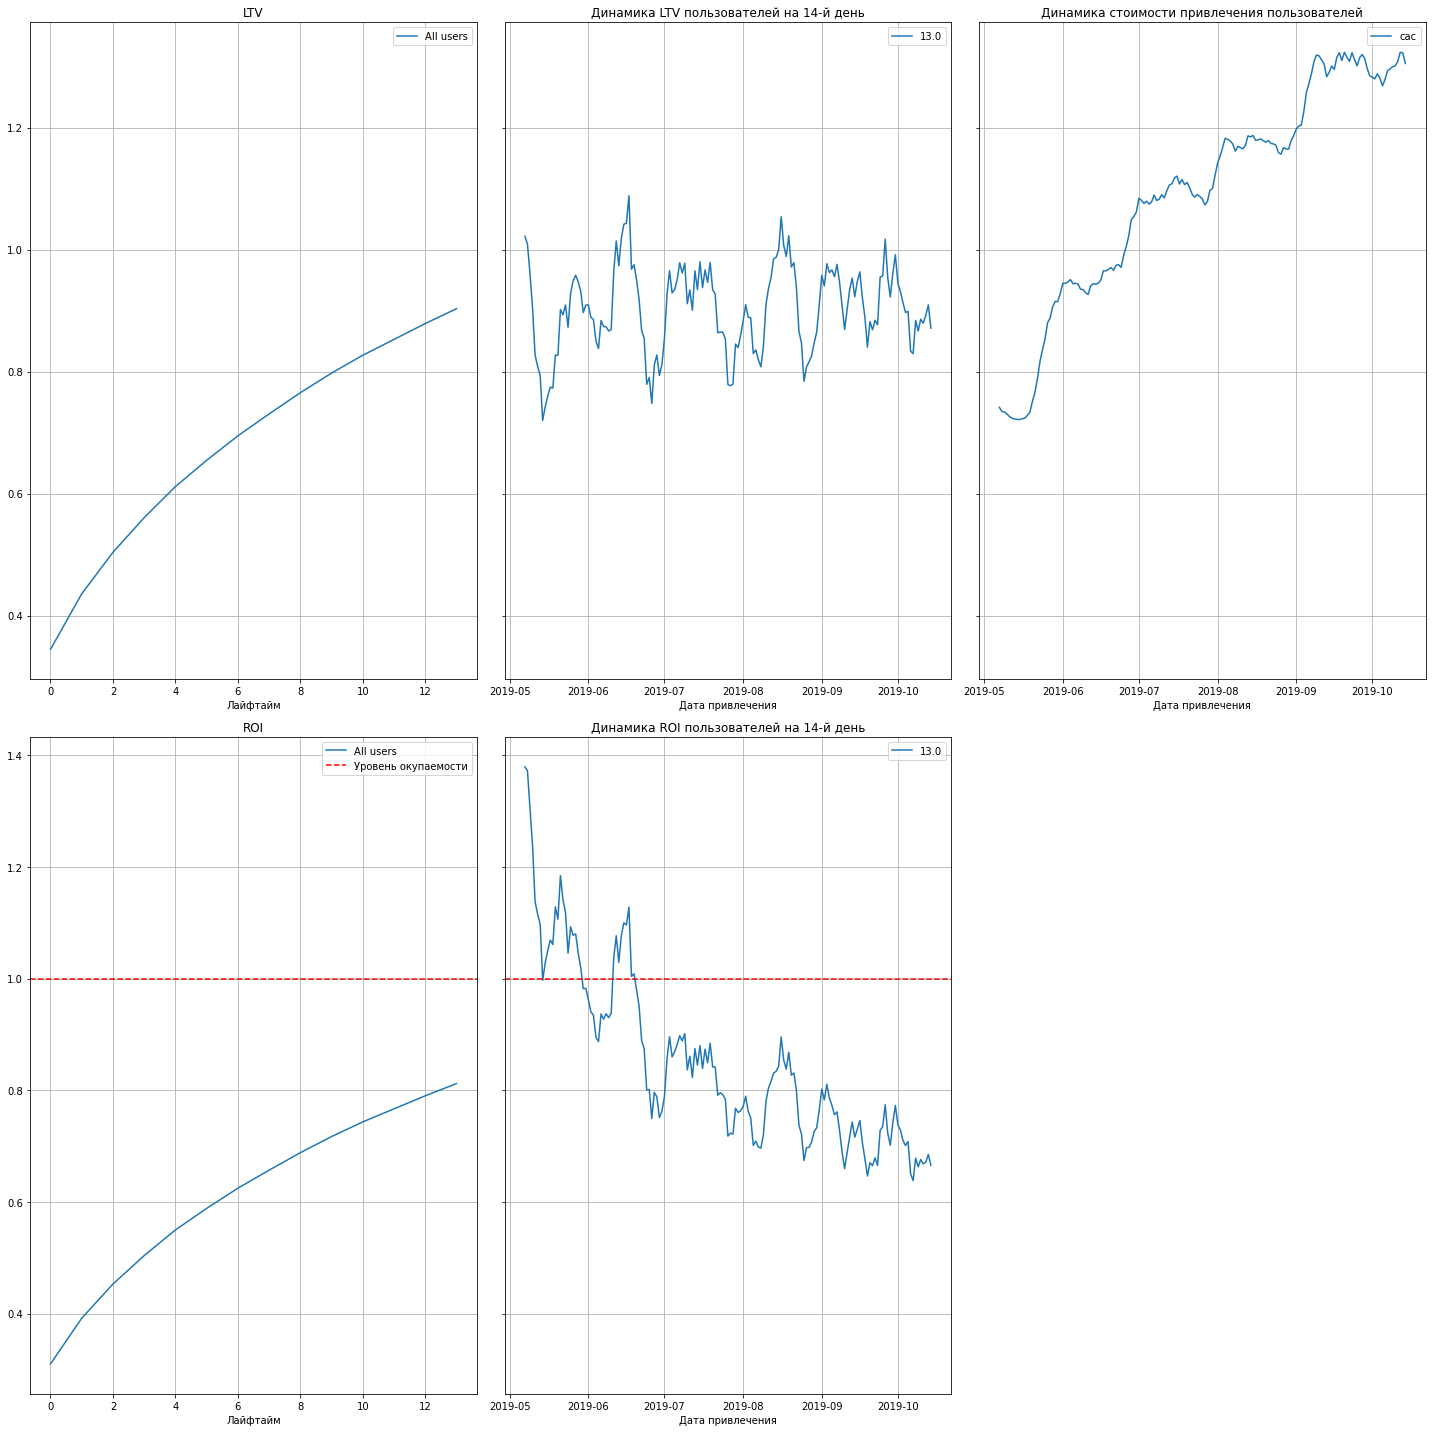

In [21]:
profiles = profiles.query('channel != "organic"')
#Считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

При увеличивающемся рекламном бюджете, реклама не окупается вообще, о горизонте в 14 дней речи не идёт. Данная проблематика наблюдается с июня: клиенты перестали окапаться в двухнедельном лайфтайме. 

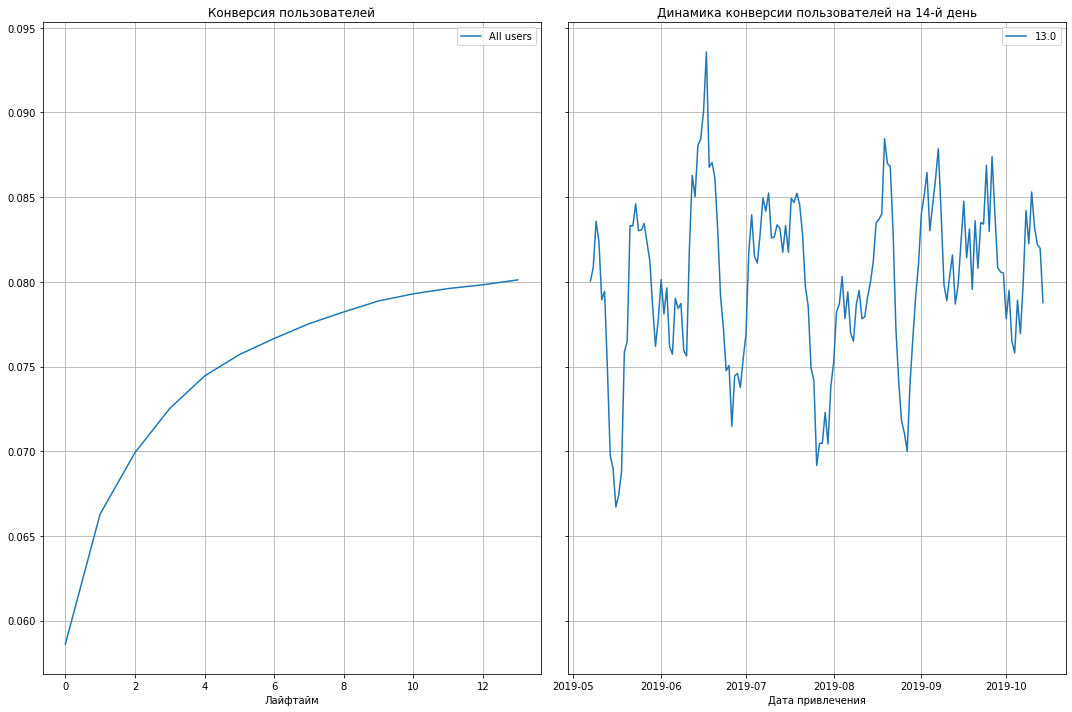

In [22]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)

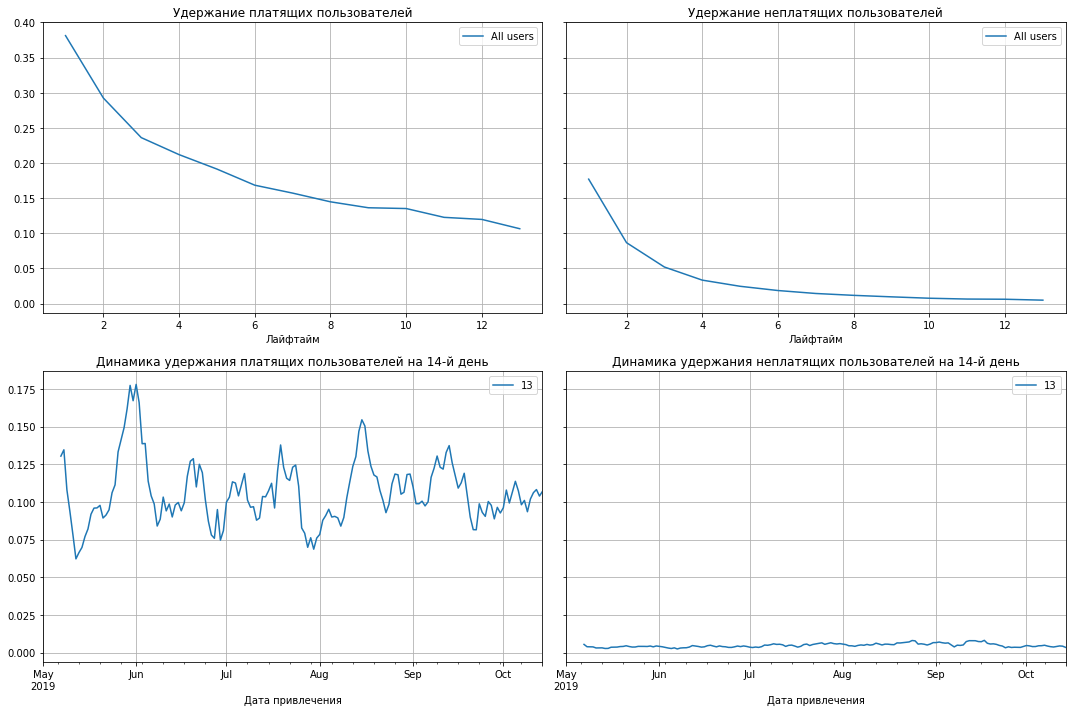

In [23]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon)

plot_retention(retention_grouped, retention_history, analysis_horizon)

На первый взгляд, граифики по лайстаймам выглядят гармонично, но динамика хромает. Удержание резко просело после июня, конверсия в июле августе и сентябре также была значительно хуже.

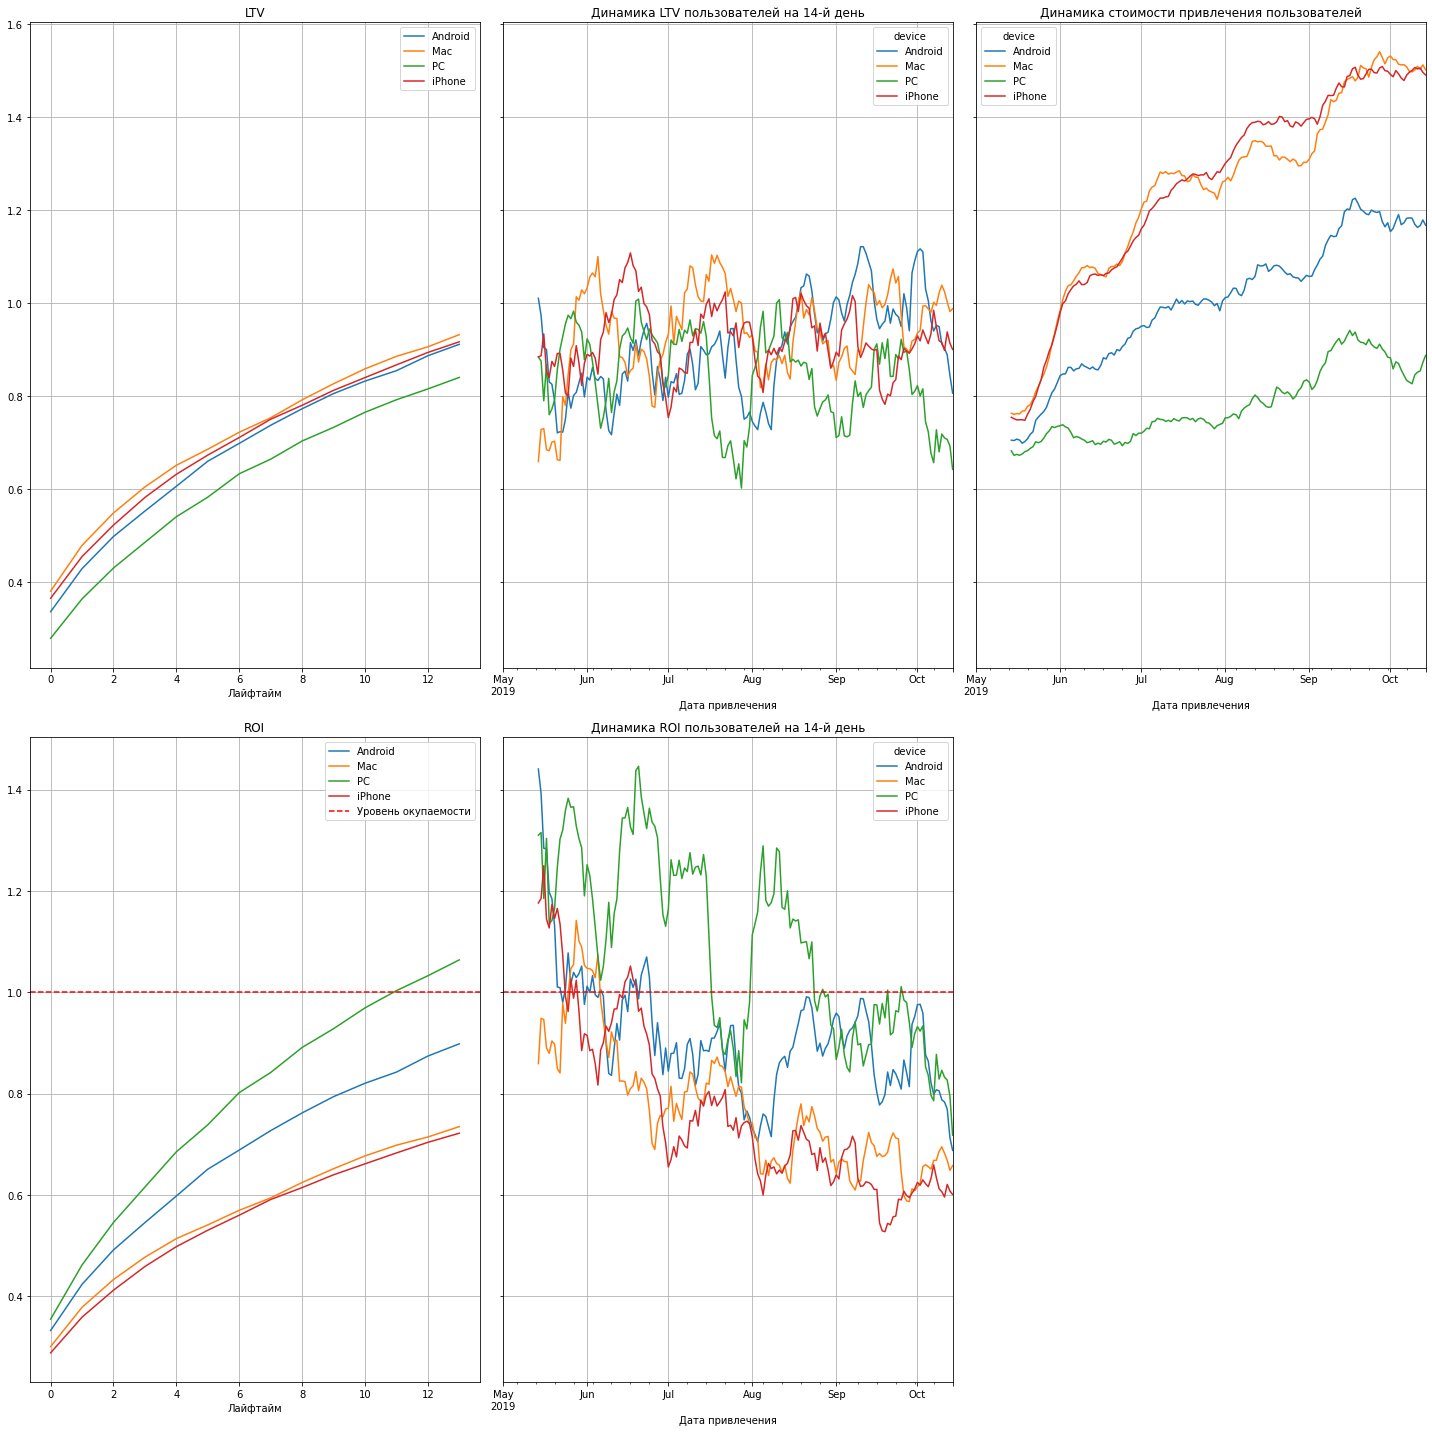

In [24]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

Единственный тип устройств, на котором реклама начинает окупаться на двухнедельном горизонте - PC. Это связано с относительно низкой стоимостью привлечения клиентов. Второй по экономической выгоде тип устров - Android, но у него дела обстоят хуже, т.к. стоимость привлечения выше.

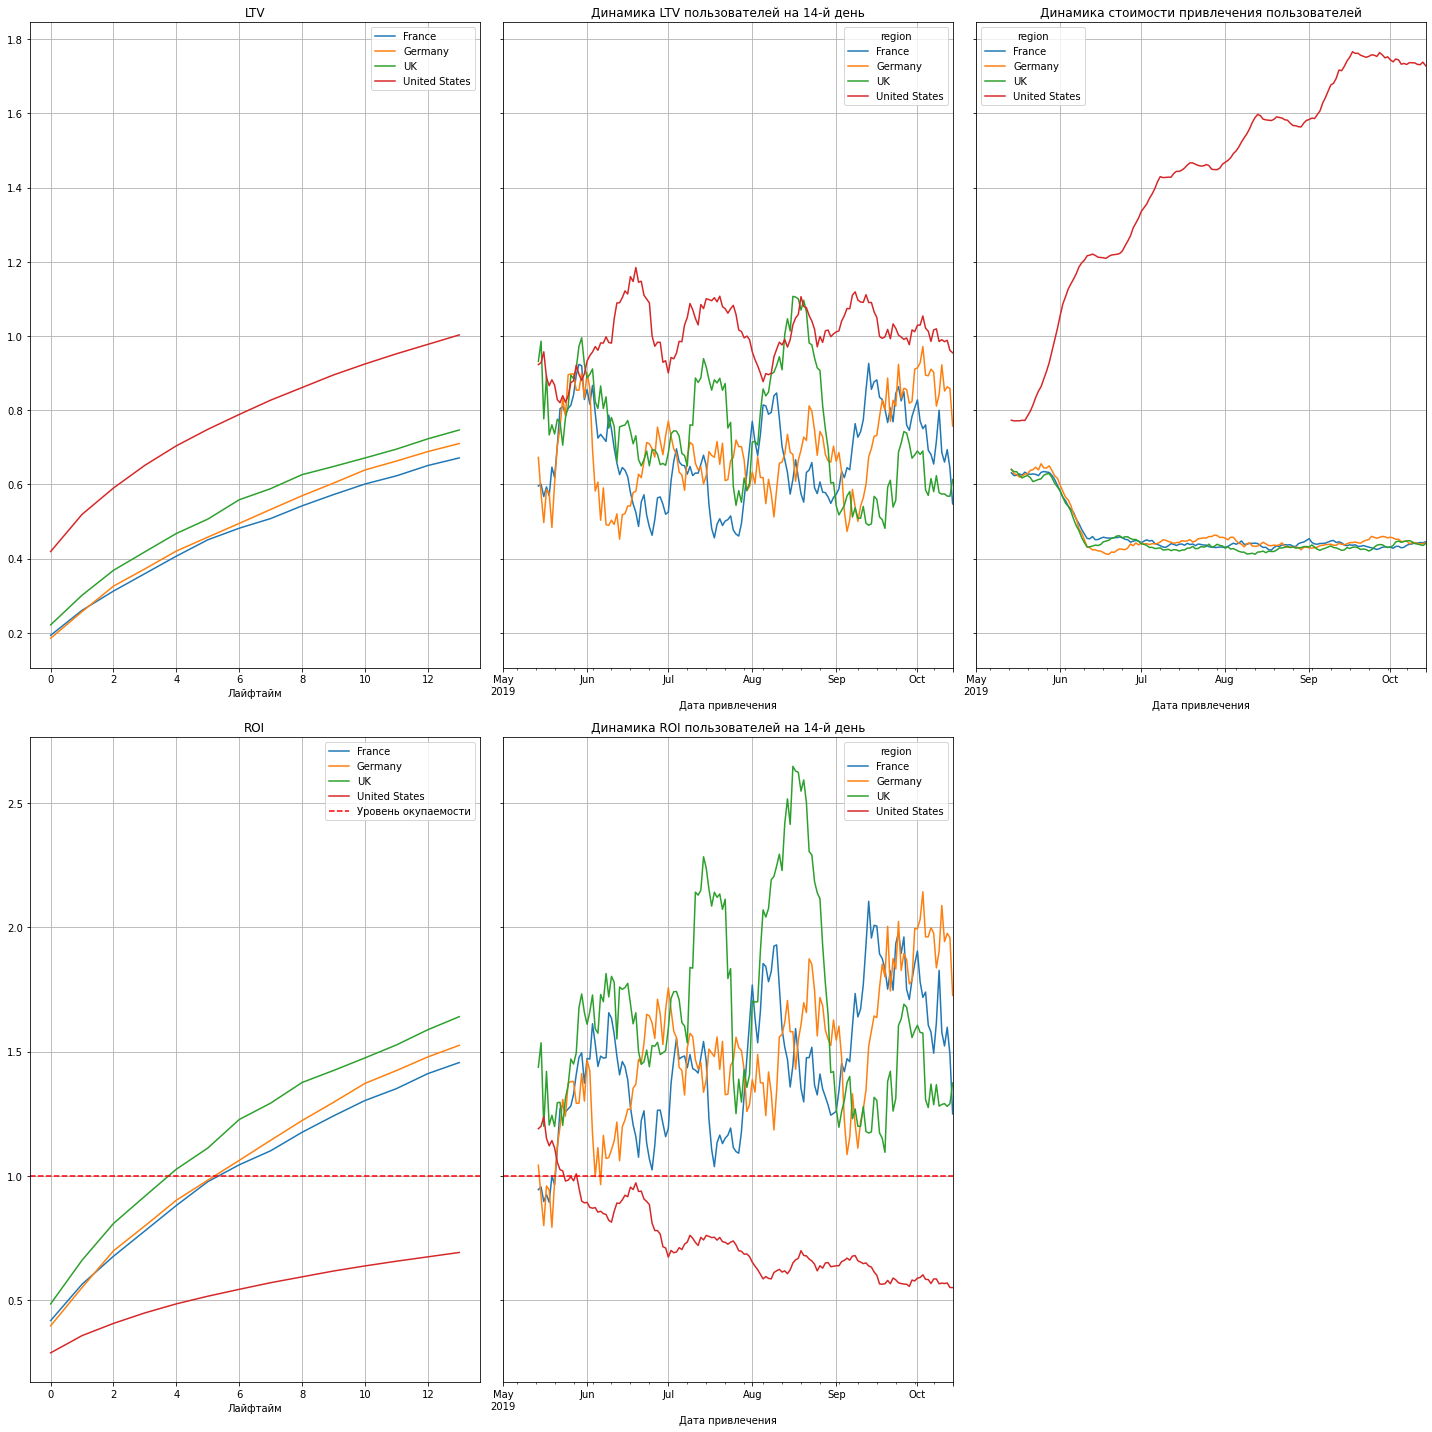

In [25]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

Несмотря на огромное количество привлеченных пользователей из США, они беспозелны, быстро приходят и так же быстро уходят, а также дорого обходятся заказчику.
Затраты на рекламу в Европе остаются неизменными и окупаются, а вот в США растут и перестали окупаться с июня.

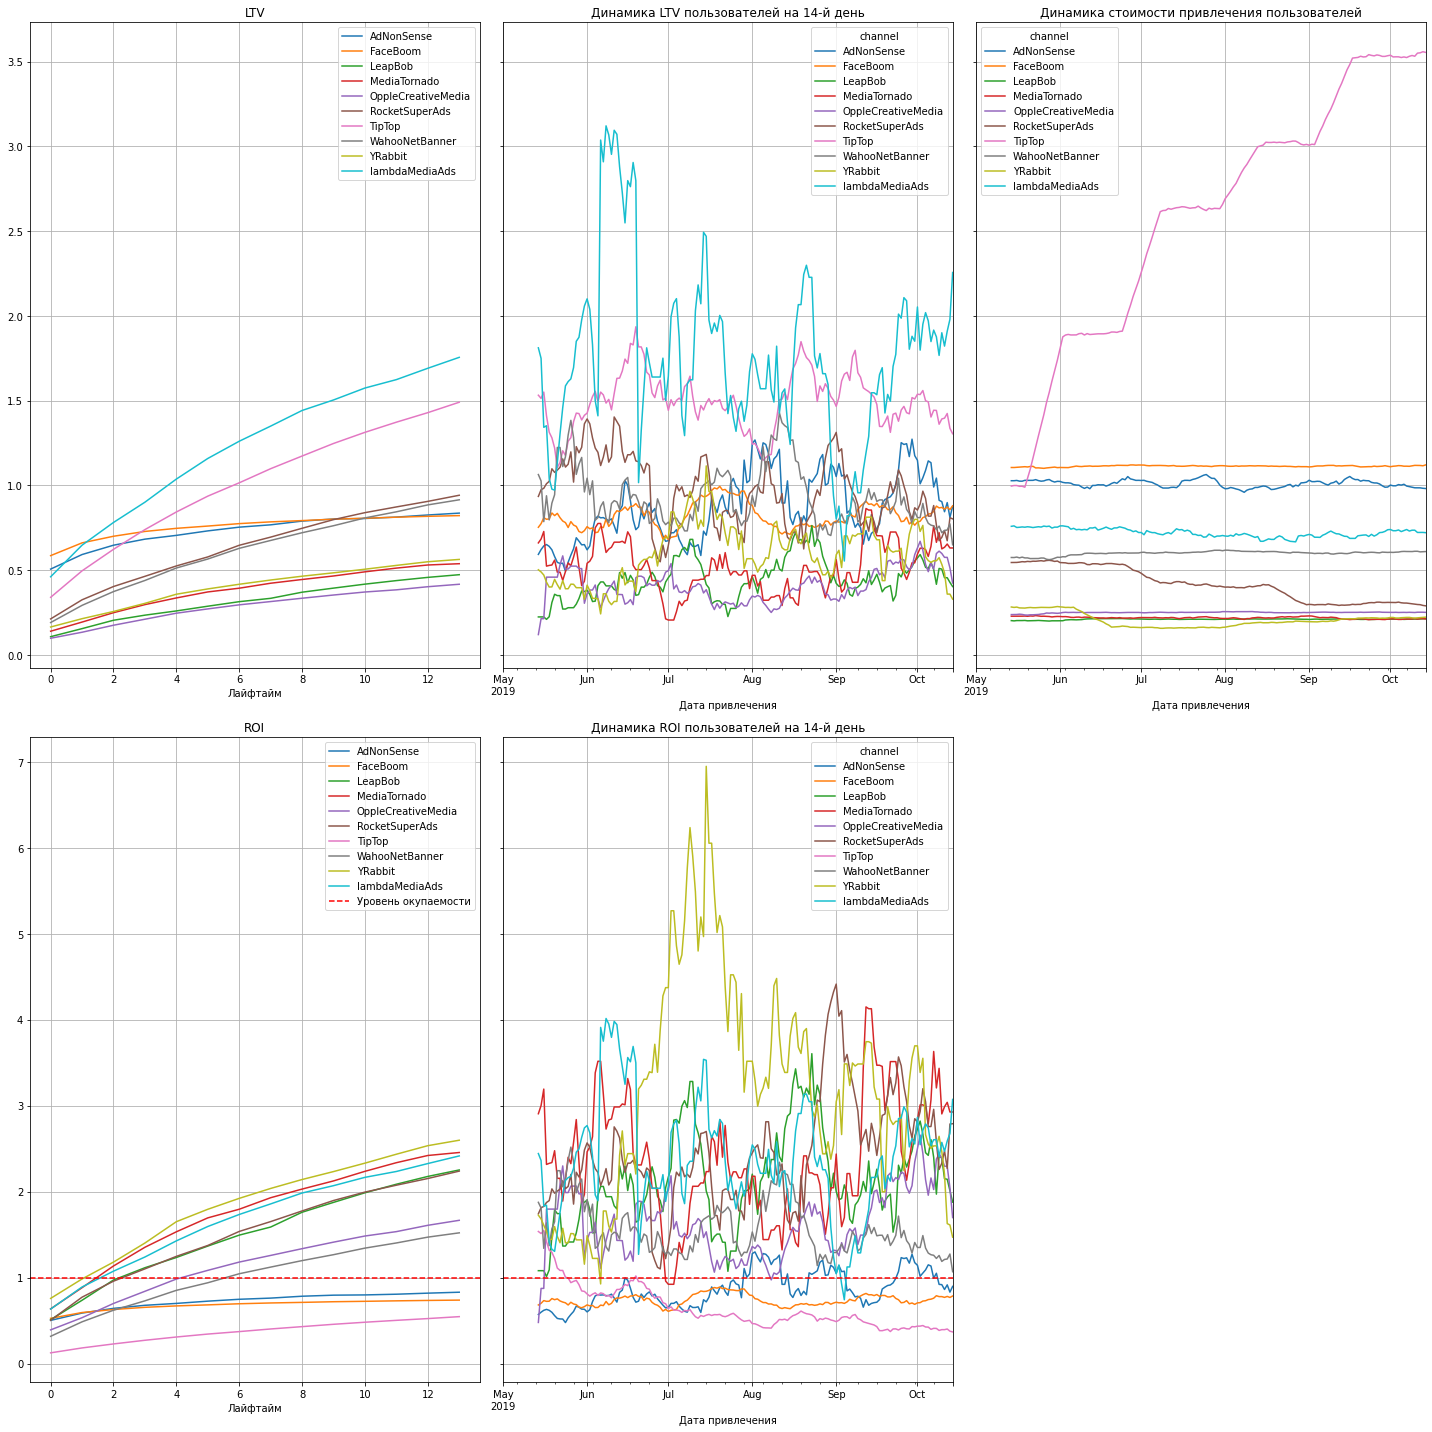

In [26]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon, window=14
)

На двухнедельном лайфтайме затраты на первую тройку компаний (на которые тратится практически весь рекламный бюджет) - не окупаются, затраты на рекламу в TipTop и FaceBoom вообще не окупаются. Затраты на рекламу в TipTop увеличиваются каждый месяц,
Перспективным каналом кажется lambdaMediaAds - низкая стоимость привлечения и высокие показатели пожизненной ценности клиента.

Итак, в результате анализа окупаемости рекламы можно сделать следующие выводы:

1. у заказчика нет экономически эффектиных каналов прилвечения;
2. Это связано с низкой окупаемостьюв США, как основной страны;
3. Пользователи из США конверсируются больше, но есть проблемы с удержанием платящих пользователей;
4. Один из самых проблемных каналов - FaceBoom (не окупается имея второе место по сумме затрат на рекламу; TipTop - неоправданно высокий рост САС.
5. По устройствам отмечу экономическую выгоду в PCи платформе Android.

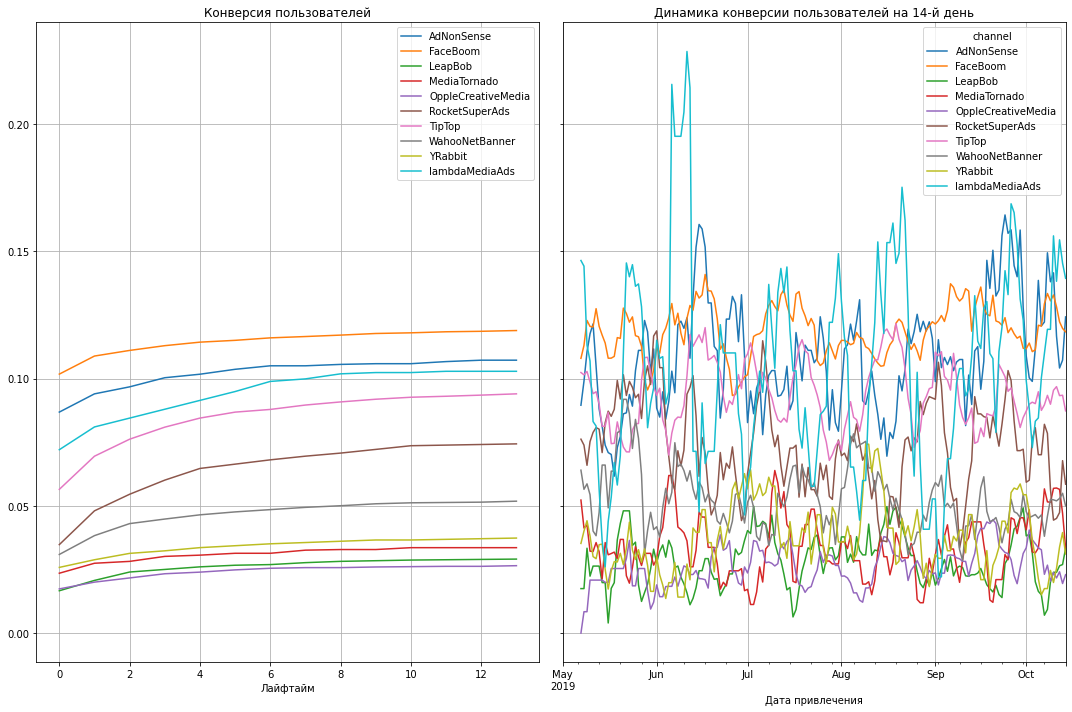

In [27]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, analysis_horizon, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, analysis_horizon)




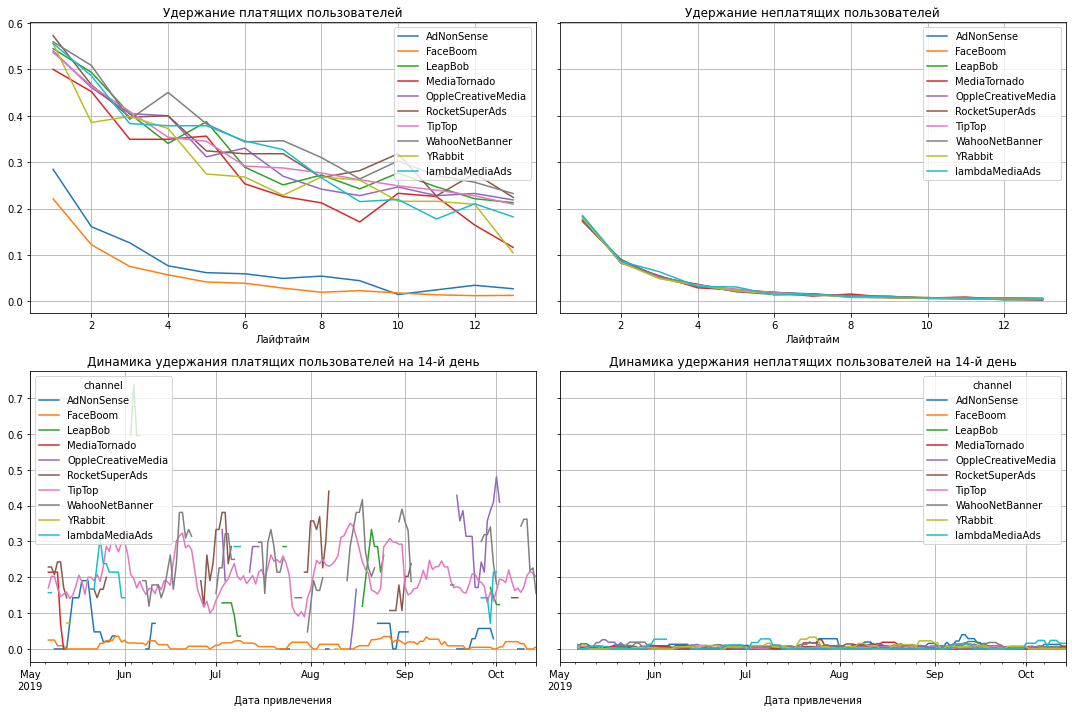

In [28]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, analysis_horizon,dimensions=dimensions)

plot_retention(retention_grouped, retention_history, analysis_horizon)


### Выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Компания-заказчик представлена на рынке Европы (Германия, Франция и Великобритания) и в США. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

Мы проанализировали данные, предоставленные компанией-заказчиком:
-лог сервера с данными об их посещениях,
-выгрузку покупок за этот период,
-рекламные расходы.
В результате исследования было выявлено, что основной причиной финансовых проблем являются рекламные траты на привлечение пользователей посредством FaceBoom, TipTop в США и AdNonSence в Европе:

-высокая стоимость привлечения у этих каналов, с горизонтом событий в две недели не окупается;
-при этом, платящие пользователи FaceBoom и AdNonSence очень плохо удерживаются;
-расходы на привлечение в TipTop за полгода выросли почти в три раза.

В качестве рекомендаций предлагаем следующие направления:

-с учетом того, что подавляющее количество пользователей из США, необходиом проработать отношения с рекламными площадками этого направления:
-как вариант, отказаться от FaceBoom и перенаправить рекламные средства в пользу других каналов;
-выявить причину роста САС канала TipTop и по возможности устранить ее. Если это невозможно, то отказаться от этой рекламной площадки в пользу других;
-обратить внимание на европейский рынок, например, увеличить расходы на рекламу в lambdaMediaAds и снизить в AdNonSense;
-поработать с органическими пользователями: это существенная доля дохода приложения.